# Yelp Dataset Analysis

In [1]:
# Set up
import json
import pandas as pd
import datetime
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# This style emulates the look and feel of the famous data journalist Nate Silver's site.
%matplotlib inline
plt.style.use('fivethirtyeight')

import seaborn as sns
sns.set()
sns.set_context("talk")

import gmaps
import gmaps.datasets
gmaps.configure(api_key="AI...")  # Use your google API

import utils
import kmeans

In [2]:
# Get dataset
utils.help_directory('dataset.zip')

In [3]:
# Load json files
reviews = pd.DataFrame.from_records(utils.load_file('dataset/review.json'))
reviews = reviews[['review_id', 'date', 'stars', 'text', 'cool', 'funny', 'useful', 'business_id', 'user_id']]

users =  pd.DataFrame.from_records(utils.load_file('dataset/users.json'))
users = users[['user_id', 'name', 'yelping_since', 'average_stars', 'review_count', 'fans', 'cool', 'funny', 'useful']]

business =  pd.DataFrame.from_records(utils.load_file('dataset/business.json'))
business = business[['business_id', 'name', 'is_open', 'stars', 'review_count', 'categories', 'attributes', 'state', 'city', 'postal_code', 'latitude', 'longitude']]

photos =  pd.DataFrame.from_records(utils.load_file('dataset/photos.json'))
photos = photos[['photo_id', 'business_id', 'label', 'caption']]

## Phase 1:  Reviews

In [4]:
reviews['date'] = reviews['date'].apply(lambda d: datetime.datetime.strptime(d, '%Y-%m-%d'))
reviews.head()

review_id       date  stars  \
0  v0i_UHJMo_hPBq9bxWvW4w 2016-05-28      5   
1  vkVSCC7xljjrAI4UGfnKEQ 2016-05-28      5   
2  n6QzIUObkYshz4dz2QRJTw 2016-05-28      5   
3  MV3CcKScW05u5LVfF6ok0g 2016-05-28      5   
4  IXvOzsEMYtiJI0CARmj77Q 2016-05-28      4   

                                                text  cool  funny  useful  \
0  Love the staff, love the meat, love the place....     0      0       0   
1  Super simple place but amazing nonetheless. It...     0      0       0   
2  Small unassuming place that changes their menu...     0      0       0   
3  Lester's is located in a beautiful neighborhoo...     0      0       0   
4  Love coming here. Yes the place always needs t...     0      0       0   

              business_id                 user_id  
0  0W4lkclzZThpx3V65bVgig  bv2nCi5Qv5vroFiqKGopiw  
1  AEx2SYEUJmTxVVB18LlCwA  bv2nCi5Qv5vroFiqKGopiw  
2  VR6GpWIda3SfvPC-lg9H3w  bv2nCi5Qv5vroFiqKGopiw  
3  CKC0-MOWMqoeWf6s-szl8g  bv2nCi5Qv5vroFiqKGopiw  
4  ACFtxLv8pGrrxMm6EgjreA  bv2nCi5Qv5vroFiqKGopiw

In [5]:
# Incluing 100000 reviews from yelp users.
reviews.shape

(100000, 9)

### 1.1 Reviews-Stars

In [6]:
review_stars = reviews['stars'].value_counts()
review_stars_percent = review_stars.apply(lambda i : i / len(reviews))
review_stars_percent

5    0.42720
4    0.23897
1    0.13267
3    0.11807
2    0.08309
Name: stars, dtype: float64

When we count the number of reviews for different stars, it is clear to see that most people `42.7%` tend to give 5-star or 4-star ratings `23.9%`, which means that for about `66.6%` people are at least satisfied with their businesses. And then, the third highest rating star is 1-star with `13.3%`. Of course, this data makes sense because most customers only write reviews when they have very positive or negative experiences. Writing reviews takes a decent amount of effort, so unless a customer is highly motivated or so disappointed, it’s unlikely that they write anything at all (barring external factors like incentives).

NBC news published an article [Online reviews: Here's what's behind all those 5 star ratings](https://www.nbcnews.com/better/business/does-five-star-online-review-really-mean-product-good-ncna870901), it stated that people nowadays tend to give either perfect reviews like 5-star and 4-star or offer awful ratings such as 1-star. Sometimes ratings can't reveal the information matters to people because of fake or misleading reviews that can bump star ratings up or down. 

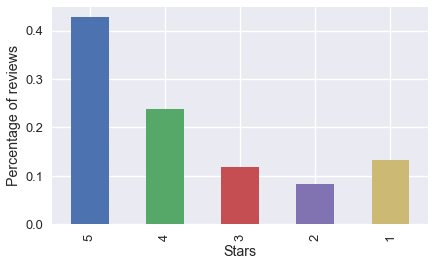

In [7]:
review_stars_percent.sort_index(ascending=False).plot('bar')
plt.ylabel('Percentage of reviews')
plt.xlabel('Stars');

### 1.2 Reviews-Assessment

After we find out that majority of people tend to give a high-star reviews, how do other users or customers feel about those reviews? What about those low-star reviews? In the `reviews` dataframe there are three columns called `useful`, `cool` and `funny`, which are number of votes about users' feeling for those reviews. We can try to build the connection between the stars they give to business and other users' feeling about their reviews.

In [8]:
# Filter out unavailable reviews. At least have one vote in all three options.
avai_reviews = reviews.query("useful > 0 and cool > 0 and funny > 0")
print("Number of available reviews: ", len(avai_reviews))

Number of available reviews:  13273


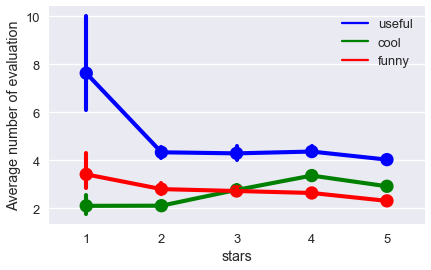

In [9]:
import matplotlib.lines as mlines
sns.pointplot(x = 'stars', y = 'useful', data = avai_reviews, color="blue")
sns.pointplot(x = 'stars', y = 'cool', data = avai_reviews, color="green")
sns.pointplot(x = 'stars', y = 'funny', data = avai_reviews, color="red")
lg1 = mlines.Line2D([], [], color='blue', label='useful')
lg2 = mlines.Line2D([], [], color='green', label='cool')
lg3 = mlines.Line2D([], [], color='red', label='funny')
plt.ylabel('Average number of evaluation')
plt.legend(handles=[lg1, lg2, lg3]);

In the plot we can see that the number of useful votes is always greater than other two. 
- For `useful` reviews, the number of `1-star` votes is maximal, nearly twice of other four kinds of stars. 
- For `funny` reviews, the more stars people offer, they less votes of `funny` they can get. 
- For `cool` reviews, high-star reviews can get more votes.

More votes usually imply that users are more agree with those reviews. Like `useful`, people feel that those `1-star` reviews are more helpful, or furthermore, more reliable. People think extreme `low-star` reviews can reveal and offer more imformation about that business. While for `high-star` reviews, customers seemingly hold a skeptical attitude, especially comparing with `1-star` review. 

### 1.3 Reviews-Sentimenet Analysis

It turns out that we can use the words in texts to calculate a measure of the sentiment of the people from their reviews. For example, the sentence "Love coming here" has positive sentiment, whereas the sentence "Food is very bland" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "Love coming here." is more positive than "Like coming here."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of users' reviews. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. For example:

In [10]:
print(''.join(open("vader_lexicon.txt").readlines()[:5]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]



In [11]:
lexicon = pd.read_csv('vader_lexicon.txt', sep='\t',
                   usecols=[0, 1], header=None, names=['token', 'polarity'],
                   index_col='token')
lexicon.head()

polarity
token          
$:         -1.5
%)         -0.4
%-)        -1.5
&-:        -0.4
&:         -0.7

Now, let's use this lexicon to calculate the overall sentiment for each of review's text. Here's the basic idea:

1. For each review's text, find the sentiment of each word.
2. Calculate the sentiment of each review's text by taking the sum of the sentiments of its words.

Firstly, we need to lowercase the text since the lexicon is also lowercase. 
And then,  we need to replace the punctuation with a space since it will cause us to fail to match words. 

In [12]:
reviews['text'] = reviews['text'].str.lower()
regex = '[^\w\s]'
reviews['text'] = reviews['text'].apply(lambda text : re.sub(regex, ' ', text))
# Change the review_id as index.
simplify_reviews = reviews[['review_id', 'text']].set_index('review_id')

Secondly, we split the text to each word and create a new dataframe. Column `location` means the index of each word in text and `word` is individual word in text. 

In [13]:
words = (
    simplify_reviews['text']
    .str.split(expand=True)
    .stack()
    .reset_index(level=1)
    .rename(columns={'level_1': 'location', 0: 'word'})
)
words.head()

location   word
review_id                              
v0i_UHJMo_hPBq9bxWvW4w         0   love
v0i_UHJMo_hPBq9bxWvW4w         1    the
v0i_UHJMo_hPBq9bxWvW4w         2  staff
v0i_UHJMo_hPBq9bxWvW4w         3   love
v0i_UHJMo_hPBq9bxWvW4w         4    the

Lastly, we merge dataframe `words` with previous `lexicon` dataframe, sum the `polarity` of each word from the same text and add a new column `polarity` to the `reviews`.

In [14]:
helper = words.reset_index().merge(lexicon.reset_index(), how = 'left', left_on='word', right_on='token')
p = helper.groupby(['review_id']).sum()[['polarity']].reset_index()
reviews = reviews.merge(p, left_on='review_id', right_on='review_id')
# Sort the polarity of review from highest to lowest.
reviews.sort_values('polarity', ascending = False).head()

review_id       date  stars  \
12629  _cLK95Db4mvDwAfOupS7Cw 2016-06-20      4   
7744   QoJAmSEJB2AW46ba56aFRQ 2011-05-01      3   
12600  YGTyhmWf5M1oUeFDAyCwuw 2015-11-23      5   
44351  4n0RFOsAySGiTzKqU3TfdQ 2016-09-05      5   
24855  rKGqy9HKtuO6cSsQANnV-g 2017-08-29      5   

                                                    text  cool  funny  useful  \
12629  i came here yesterday for father s day dinner ...     0      0       3   
7744   5 second summary  mediocre average food  excep...     0      0       1   
12600  i came back to miku for dinner after just comi...     7      1       9   
44351  best new restaurant in henderson and beyond  b...     4      3       5   
24855  a maz ing      i can t say enough great things...     0      0       1   

                  business_id                 user_id  polarity  
12629  -zuJkmIjdRahT_yHED-62g  YMTcBb6Vj54rd_NuFtb8QQ     159.0  
7744   r6CaBBT6oW6laBgkrWbZFQ  XuCbLgo9j1q5dDh9251vkg     145.8  
12600  0a2O150ytxrDjDzXNfRWkA  YMTcBb6Vj54rd_NuFtb8QQ     134.7  
44351  BQqwIYQuo2W94smjrBjy5g  uaC8Ku7fqwD4Gh6L1YabAg     130.0  
24855  4KmrrhtfnngTVFa2d5LAjg  Y7EkNdRl_WCML9zo9lw1nw     129.2

When we plot the polarity of each review by their received stars, we can see that nearly it makes much sense. For high star reviews they usually have higher polarity and vice versa. But when comparing 4-star with 5-star reviews, their polarity nearly are equal, actually average polarity of 4-star review is even a little higher than 5-star's. Mostly it is because an outlier with polarity `159` which is maximal in all reviews only gives a 4-star review, and also the second highest polarity `145.8` even gives a worse 3-star review. 

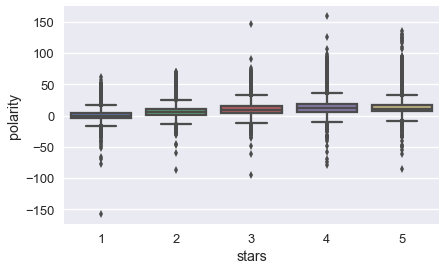

In [15]:
sns.boxplot(x = 'stars', y = 'polarity', data = reviews);

In [16]:
print("Average polarity of 5-star review: ", reviews[reviews['stars'] == 5]['polarity'].mean())
print("Average polarity of 4-star review: ", reviews[reviews['stars'] == 4]['polarity'].mean())
print("Average polarity of 3-star review: ", reviews[reviews['stars'] == 3]['polarity'].mean())
print("Average polarity of 2-star review: ", reviews[reviews['stars'] == 2]['polarity'].mean())
print("Average polarity of 1-star review: ", reviews[reviews['stars'] == 1]['polarity'].mean())

Average polarity of 5-star review:  13.3567743446
Average polarity of 4-star review:  13.5225593171
Average polarity of 3-star review:  11.0896586771
Average polarity of 2-star review:  6.6462871585
Average polarity of 1-star review:  0.379980402502


We can also compare sentiment of review by whether the text of the review contains a certain keyword. For example:

In [17]:
def keyword_sentiment(keyword1, keyword2):
    sns.distplot(reviews[reviews['text'].str.contains(keyword1)]['polarity']) # keyword1
    sns.distplot(reviews[reviews['text'].str.contains(keyword2)]['polarity']) # keyword2
    plt.legend([keyword1, keyword2])
    plt.xlim([-50,50]);

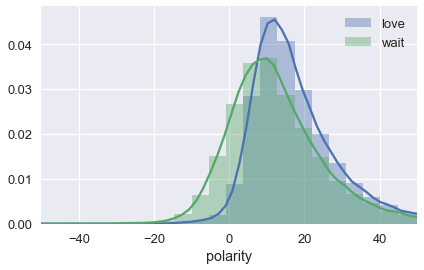

In [18]:
keyword_sentiment('love', 'wait')

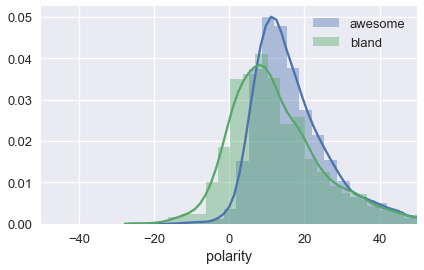

In [19]:
keyword_sentiment('awesome', 'bland')

## Phase 2: Business

### 2.1 Las Vegas Restaurants

Businesses tend to appear in clusters, like restaurants. In this phase, we will devise a way to group together restaurants that are close to each other in **Las Vegas**.

The [k-means algorithm](https://en.wikipedia.org/wiki/K-means_clustering) is a method for discovering the centers of clusters. It is called an unsupervised learning method because the algorithm is not told what the correct clusters are; it must infer the clusters from the data alone.The k-means algorithm finds k centroids within a dataset that each correspond to a cluster of inputs. To do so, k-means begins by choosing k centroids at random, then alternates between the following two steps:

1. Group the restaurants into clusters, where each cluster contains all restaurants that are closest to the same centroid.
2. Compute a new centroid (average position) for each new cluster.

This [visualization](http://tech.nitoyon.com/en/blog/2013/11/07/k-means/) is a good way to understand how the algorithm works.

In [20]:
# Get all the restaurants in Las Vegas.
business['restaurant'] = business['categories'].apply(lambda c : 'Restaurants' in c)
las_vegas_rest = business.query("city == 'Las Vegas' and restaurant == True")
print("Number of restaurants in Las Vegas: ", len(las_vegas_rest))
las_vegas_rest.head()

Number of restaurants in Las Vegas:  1692


business_id                     name  is_open  stars  \
52   Pd52CjgyEU3Rb8co6QfTPw  Flight Deck Bar & Grill        1    4.0   
53   4srfPk1s8nlm1YusyDUbjg                   Subway        1    2.5   
54   n7V4cD-KqqE3OXk0irJTyA                GameWorks        1    3.0   
91   F0fEKpTk7gAmuSFI0KW1eQ           Cafe Mastrioni        0    1.5   
122  Wpt0sFHcPtV5MO9He7yMKQ               McDonald's        1    2.0   

     review_count                                         categories  \
52             13  [Nightlife, Bars, Barbeque, Sports Bars, Ameri...   
53              6               [Fast Food, Restaurants, Sandwiches]   
54            349  [Arcades, Arts & Entertainment, Gastropubs, Re...   
91              3                             [Italian, Restaurants]   
122            20                  [Restaurants, Fast Food, Burgers]   

                                            attributes state       city  \
52   {'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...    NV  Las Vegas   
53   {'GoodForMeal': {'dessert': False, 'latenight'...    NV  Las Vegas   
54   {'RestaurantsTableService': True, 'GoodForMeal...    NV  Las Vegas   
91   {'GoodForMeal': {'dessert': False, 'latenight'...    NV  Las Vegas   
122  {'RestaurantsTableService': False, 'GoodForMea...    NV  Las Vegas   

    postal_code   latitude   longitude  restaurant  
52        89119  36.066914 -115.170848        True  
53        89119  36.064652 -115.118954        True  
54        89119  36.068259 -115.178877        True  
91        89103  36.111057 -115.241688        True  
122       89121  36.130013 -115.109310        True

We load all the restaurants in Las Vegas to an array called `rests` which contains `name`, `position(latitude, longitude)`, `categories`, `stars` and `review_count`.

In [21]:
rests = utils.load_las_vegas_rest('dataset/business.json')
rests[0]

['Flight Deck Bar & Grill',
 (36.0669136, -115.1708484),
 ['Nightlife',
  'Bars',
  'Barbeque',
  'Sports Bars',
  'American (New)',
  'Restaurants'],
 4.0,
 13]

Let's plot a heatmap of restaurants in Las Vegas:

In [51]:
# load a Numpy array of (latitude, longitude) pairs
rests_locations = [rest[1] for rest in rests]
fig = gmaps.figure()
rests_layer = gmaps.heatmap_layer(rests_locations)
fig.add_layer(rests_layer)
# fig    # Please unremark this line when running the cell.

<img src="map1.png">

In [52]:
def k_m(k):
    # Use k-means algorithm
    centroids = kmeans.k_means(rests, k)
    return centroids
k_means_6 = k_m(6) # Get six centroids (latitude, longitude)
k_means_6

[[36.04190402285771, -115.15140516991347],
 [36.102234309278714, -115.27921021210042],
 [36.150191858976534, -115.105384091057],
 [36.11985851636887, -115.17853350547645],
 [36.267064944582025, -115.25704555050564],
 [36.18351651409624, -115.24953595058021]]

Add the centroids on original heatmap:

In [54]:
centroids_layer = gmaps.symbol_layer(k_means_6, fill_color="blue", stroke_color="blue", scale=5)
fig.add_layer(centroids_layer)
# fig    # Please unremark this line when running the cell.

<img src="map2.png">